In [1]:
# Pairs
import pandas as pd

In [2]:
df = pd.read_csv("human_lr_pair.txt", sep = "\s+")
df

,lr_pair,ligand_gene_symbol,receptor_gene_symbol,ligand_gene_id,receptor_gene_id,ligand_ensembl_protein_id,receptor_ensembl_protein_id,ligand_ensembl_gene_id,receptor_ensembl_gene_id,evidence
0,SEMA3F_PLXNA3,SEMA3F,PLXNA3,6405,55558,ENSP00000002829,ENSP00000358696,ENSG00000001617,ENSG00000130827,15721238
1,SEMA3F_PLXNA1,SEMA3F,PLXNA1,6405,5361,ENSP00000002829,ENSP00000377061,ENSG00000001617,ENSG00000114554,26156437
2,SEMA3F_NRP1,SEMA3F,NRP1,6405,8829,ENSP00000002829,ENSP00000265371,ENSG00000001617,ENSG00000099250,9883722
3,SEMA3F_NRP2,SEMA3F,NRP2,6405,8828,ENSP00000002829,ENSP00000353582,ENSG00000001617,ENSG00000118257,15721238
4,CX3CL1_CX3CR1,CX3CL1,CX3CR1,6376,1524,ENSP00000006053,ENSP00000351059,ENSG00000006210,ENSG00000168329,"10699158,24218476"
...,...,...,...,...,...,...,...,...,...,...
3393,CGA_GPR84,CGA,GPR84,1081,53831,ENSP00000482232,ENSP00000450310,ENSG00000135346,ENSG00000139572,32196115
3394,ASIP_MC1R,ASIP,MC1R,434,4157,ENSP00000454804,ENSP00000451605,ENSG00000101440,ENSG00000258839,12851328
3395,VEGFA_ITGB3,VEGFA,ITGB3,7422,3690,ENSP00000478570,ENSP00000452786,ENSG00000112715,ENSG00000259207,32196115
3396,APELA_APLNR,APELA,APLNR,100506013,187,ENSP00000484618,ENSP00000475344,ENSG00000248329,ENSG00000134817,28663440


In [3]:
pairs = pd.melt(df, id_vars=['ligand_ensembl_gene_id', 'receptor_ensembl_gene_id'], value_vars=['ligand_gene_symbol', 'receptor_gene_symbol'])
pairs["variable"] = ["LIGAND" if x == "ligand_gene_symbol" else "RECEPTOR" for x in pairs["variable"]]
values = []


for ind, row in pairs.iterrows():
    if row["variable"] == "LIGAND":
        values.append(row['ligand_ensembl_gene_id'])
    else:
        values.append(row['receptor_ensembl_gene_id'])

pairs['ID'] = values
pairs.rename(columns={"variable": "type", "value": "gene"}, inplace = True)
pairs = pairs.drop(columns=['ligand_ensembl_gene_id', 'receptor_ensembl_gene_id']).drop_duplicates()
pairs

,type,gene,ID
0,LIGAND,SEMA3F,ENSG00000001617
4,LIGAND,CX3CL1,ENSG00000006210
5,LIGAND,HEBP1,ENSG00000013583
9,LIGAND,DCN,ENSG00000011465
12,LIGAND,GRN,ENSG00000030582
...,...,...,...
6710,RECEPTOR,GPR75,ENSG00000119737
6711,RECEPTOR,VSIR,ENSG00000107738
6725,RECEPTOR,CD72,ENSG00000137101
6731,RECEPTOR,TRPM2,ENSG00000142185


In [4]:
ids = "\n".join([str(x) for x in pairs["ID"].dropna()])
with open("list_for_entrez.txt", "w+") as fh:
    fh.write(ids)

In [5]:
from Bio import SeqIO

seqs = [s for s in SeqIO.parse("mart_export.txt", "fasta")]
for s in seqs:
    s.id = s.id.split("|")[0]
    
raw_seqs = [str(s.seq).replace("N", "") for s in seqs]
ids = [str(s.id) for s in seqs]
seq_df = pd.DataFrame({"seq": raw_seqs, "ID": ids}).drop_duplicates()
seq_df

,seq,ID
0,ATGCGTCCCCACCTGTCGCCGCCGCTGCAGCAGCTACTACTGCCGG...,ENSG00000080293
1,ATGAACCGGGGAGTCCCTTTTAGGCACTTGCTTCTGGTGCTGCAAC...,ENSG00000010610
2,ATGGCTCCGATATCTCTGTCGTGGCTGCTCCGCTTGGCCACCTTCT...,ENSG00000006210
3,ATGGCCGCGGCCTCCTCCCCGCCCAGGGCCGAGAGGAAGCGCTGGG...,ENSG00000053918
4,ATGTCCCGCCGCTCTATGCTGCTTGCCTGGGCTCTCCCCAGCCTCC...,ENSG00000008438
...,...,...
7833,ATGCCTGTGCCCTGGTTCTTGCTGTCCTTGGCACTGGGCCGAAGCC...,ENSG00000163702
7834,ATGCTGGGCATCTGGACCCTCCTACCTCTGGTTCTTACGTCTGTTG...,ENSG00000026103
7835,CGCCCGACTGCAACTGCTGACCCTGCAGAGCTGGCTGCTGGACGCA...,ENSG00000163702
7836,ATGCCTGTGCCCTGGTTCTTGCTGTCCTTGGCACTGGGCCGAAGCC...,ENSG00000163702


In [6]:
final = pd.merge(pairs, seq_df, on="ID").drop_duplicates(["type", "gene"])
final = final.loc[final["seq"] != "Sequenceunavailable"]

In [7]:
import collections
import math
import itertools
from Bio.SeqUtils import MeltingTemp as mt
from Bio.SeqUtils import molecular_weight as mw

def gc(seq):
    try:
        return (seq.count("G") + seq.count("C")) / len(seq)
    except ZeroDivisionError:
        return 0

def skew(seq):
    g = seq.count("G")
    c = seq.count("C")
    try:
        return (c - g) / (g + c)
    except ZeroDivisionError:
        return 0

def kmer(seq, size): 
    mers = set(seq[x:x+size] for x in range(len(seq) - size + 1))
    return {x: seq.count(x) for x in mers}

def possible_kmers(alphabet, size):
    return itertools.product(alphabet, repeat = size)

def shannon(seq):
    m = len(seq)
    bases = collections.Counter([tmp_base for tmp_base in seq])
 
    shannon_entropy_value = 0
    for base in bases:
        # number of residues
        n_i = bases[base]
        # n_i (# residues type i) / M (# residues in column)
        p_i = n_i / float(m)
        entropy_i = p_i * (math.log(p_i, 2))
        shannon_entropy_value += entropy_i
 
    return shannon_entropy_value * -1

In [96]:
final["A"] = final["seq"].transform(lambda x: x.count("A"))
final["T"] = final["seq"].transform(lambda x: x.count("T"))
final["G"] = final["seq"].transform(lambda x: x.count("G"))
final["C"] = final["seq"].transform(lambda x: x.count("C"))
final["gc"] = final["seq"].transform(gc)
final["skew"] = final["seq"].transform(skew)
final["shannon"] = final["seq"].transform(shannon)
final["melting_temp"] = final["seq"].transform(lambda x: mt.Tm_GC(x, strict = False))
final["molecular_weight"] = final["seq"].transform(mw)
final = final.reset_index(drop = True)
final

,type,gene,ID,seq,A,T,G,C,gc,skew,...,CCCTG,CCCTC,CCCGA,CCCGT,CCCGG,CCCGC,CCCCA,CCCCT,CCCCG,CCCCC
0,LIGAND,SEMA3F,ENSG00000001617,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,465,443,659,791,0.614928,0.091034,...,5,6,1,2,7,5,11,2,6,3
1,LIGAND,CX3CL1,ENSG00000006210,ATGGCTCCGATATCTCTGTCGTGGCTGCTCCGCTTGGCCACCTTCT...,230,205,363,396,0.635678,0.043478,...,4,2,3,4,2,0,7,3,3,4
2,LIGAND,HEBP1,ENSG00000013583,ATGTTGGGCATGATCAAGAACTCGCTGTTCGGAAGCGTAGAGACGT...,156,115,167,132,0.524561,-0.117057,...,1,1,0,1,0,0,1,0,0,0
3,LIGAND,DCN,ENSG00000011465,ATGAAGGCCACTATCATCCTCCTTCTGCTTGCACAAGTTTCCTGGG...,306,271,236,267,0.465741,0.061630,...,1,1,0,0,1,0,0,2,0,1
4,LIGAND,GRN,ENSG00000030582,ATGTGGACCCTGGTGAGCTGGGTGGCCTTAACAGCAGGGCTGGTGG...,305,351,548,578,0.631874,0.026643,...,9,2,1,1,5,4,8,6,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,RECEPTOR,QRFPR,ENSG00000186867,ATGCAGGCGCTTAACATTACCCCGGAGCAGTTCTCTCGGCTGCTGC...,162,199,191,225,0.535393,0.081731,...,2,1,0,1,1,1,1,0,1,0
1528,RECEPTOR,GPR75,ENSG00000119737,ATGAACTCAACAGGCCACCTTCAGGATGCCCCCAATGCCACCTCGC...,383,434,335,471,0.496611,0.168734,...,7,1,0,1,1,0,3,3,0,4
1529,RECEPTOR,CD72,ENSG00000137101,ATGGCTGAGGCCATCACCTATGCAGATCTGAGGTTTGTGAAGGCTC...,287,223,297,273,0.527778,-0.042105,...,2,1,0,0,0,1,0,2,0,0
1530,RECEPTOR,TRPM2,ENSG00000142185,ATGGAGCCCTCAGCCCTGAGGAAAGCTGGCTCGGAGCAGGAGGAGG...,940,808,1371,1393,0.612589,0.007959,...,15,7,4,4,10,9,12,6,9,3


In [9]:
all_kmers = ["".join(x) for x in possible_kmers("ATGC", 5)]

d = {}

for mer in all_kmers:
    d[mer] = final["seq"].str.count(mer)
d

{'AAAAA': 0       1
 1       0
 2       0
 3       2
 4       0
        ..
 1527    0
 1528    0
 1529    2
 1530    2
 1531    0
 Name: seq, Length: 1532, dtype: int64,
 'AAAAT': 0       0
 1       0
 2       0
 3       5
 4       0
        ..
 1527    1
 1528    0
 1529    2
 1530    0
 1531    0
 Name: seq, Length: 1532, dtype: int64,
 'AAAAG': 0       1
 1       0
 2       2
 3       2
 4       0
        ..
 1527    1
 1528    4
 1529    1
 1530    3
 1531    1
 Name: seq, Length: 1532, dtype: int64,
 'AAAAC': 0       0
 1       0
 2       0
 3       2
 4       0
        ..
 1527    0
 1528    1
 1529    2
 1530    2
 1531    0
 Name: seq, Length: 1532, dtype: int64,
 'AAATA': 0       0
 1       0
 2       0
 3       1
 4       0
        ..
 1527    1
 1528    0
 1529    0
 1530    0
 1531    0
 Name: seq, Length: 1532, dtype: int64,
 'AAATT': 0       0
 1       0
 2       2
 3       1
 4       0
        ..
 1527    0
 1528    2
 1529    3
 1530    0
 1531    0
 Name: seq, Length: 

In [10]:
final = pd.concat([final, pd.DataFrame(d)], axis = 1)
final

,type,gene,ID,seq,A,T,G,C,gc,skew,...,CCCTG,CCCTC,CCCGA,CCCGT,CCCGG,CCCGC,CCCCA,CCCCT,CCCCG,CCCCC
0,LIGAND,SEMA3F,ENSG00000001617,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,465,443,659,791,0.614928,0.091034,...,5,6,1,2,7,5,11,2,6,3
1,LIGAND,CX3CL1,ENSG00000006210,ATGGCTCCGATATCTCTGTCGTGGCTGCTCCGCTTGGCCACCTTCT...,230,205,363,396,0.635678,0.043478,...,4,2,3,4,2,0,7,3,3,4
2,LIGAND,HEBP1,ENSG00000013583,ATGTTGGGCATGATCAAGAACTCGCTGTTCGGAAGCGTAGAGACGT...,156,115,167,132,0.524561,-0.117057,...,1,1,0,1,0,0,1,0,0,0
3,LIGAND,DCN,ENSG00000011465,ATGAAGGCCACTATCATCCTCCTTCTGCTTGCACAAGTTTCCTGGG...,306,271,236,267,0.465741,0.061630,...,1,1,0,0,1,0,0,2,0,1
4,LIGAND,GRN,ENSG00000030582,ATGTGGACCCTGGTGAGCTGGGTGGCCTTAACAGCAGGGCTGGTGG...,305,351,548,578,0.631874,0.026643,...,9,2,1,1,5,4,8,6,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,RECEPTOR,QRFPR,ENSG00000186867,ATGCAGGCGCTTAACATTACCCCGGAGCAGTTCTCTCGGCTGCTGC...,162,199,191,225,0.535393,0.081731,...,2,1,0,1,1,1,1,0,1,0
1528,RECEPTOR,GPR75,ENSG00000119737,ATGAACTCAACAGGCCACCTTCAGGATGCCCCCAATGCCACCTCGC...,383,434,335,471,0.496611,0.168734,...,7,1,0,1,1,0,3,3,0,4
1529,RECEPTOR,CD72,ENSG00000137101,ATGGCTGAGGCCATCACCTATGCAGATCTGAGGTTTGTGAAGGCTC...,287,223,297,273,0.527778,-0.042105,...,2,1,0,0,0,1,0,2,0,0
1530,RECEPTOR,TRPM2,ENSG00000142185,ATGGAGCCCTCAGCCCTGAGGAAAGCTGGCTCGGAGCAGGAGGAGG...,940,808,1371,1393,0.612589,0.007959,...,15,7,4,4,10,9,12,6,9,3


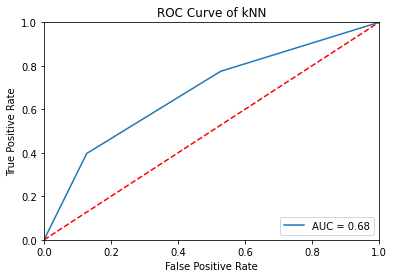

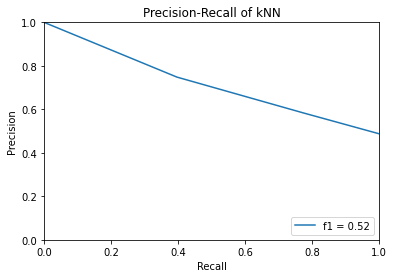

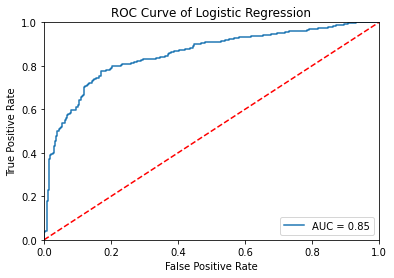

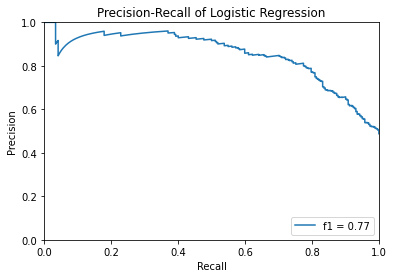

In [11]:
import vowpalwabbit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc, f1_score
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

X = final[["A", "T", "G", "C", "gc", "skew", "shannon", "melting_temp", "molecular_weight"] + all_kmers].transform(minmax_scale)
# Receptor 1, Ligand 0
Y = final["type"].transform(lambda x: 1 if x == "RECEPTOR" else 0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.35)

# KNN
model = KNeighborsClassifier(2)
model.fit(X_train, Y_train)

predictions = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
precision, recall, threshold = precision_recall_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
f1 = f1_score(Y_test, predictions)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of kNN')
plt.show()


# Logistic Reg
reg = LogisticRegression(max_iter=3000)
reg.fit(X_train, Y_train)

preds = reg.predict(X_test)
probs = reg.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)

precision, recall, threshold = precision_recall_curve(Y_test, probs)
f1 = f1_score(Y_test, preds)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of Logistic Regression')
plt.show()

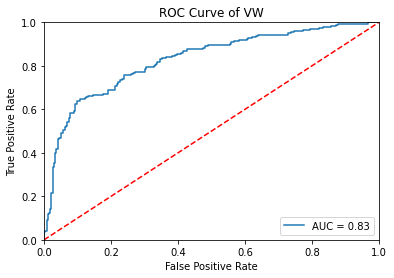

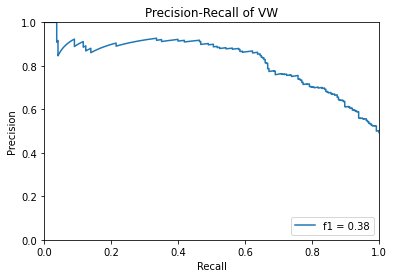

In [12]:
from vowpalwabbit.sklearn import VWClassifier
X = final[["A", "T", "G", "C", "gc", "skew", "shannon", "melting_temp", "molecular_weight"] + all_kmers].transform(minmax_scale)
# Receptor 1, Ligand 0
Y = final["type"].transform(lambda x: 1 if x == "RECEPTOR" else 0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.35)

model = VWClassifier()
model.fit(X_train, Y_train)
# predict model
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
precision, recall, threshold = precision_recall_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
f1 = f1_score(Y_test, predictions)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of VW')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of VW')
plt.show()


# Correlation

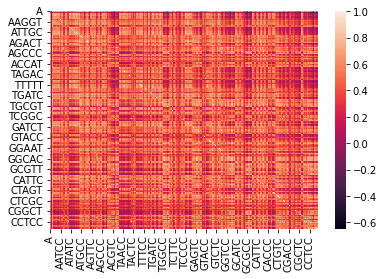

In [13]:
# Check for linear combinations
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = final.corr()

sn.heatmap(corrMatrix)
plt.show()
# Całkiem niezłe korelacje

# PCA

original shape:    (1532, 1033)
transformed shape: (1532, 13)


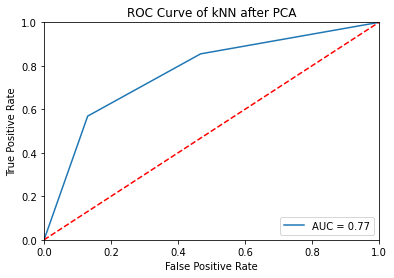

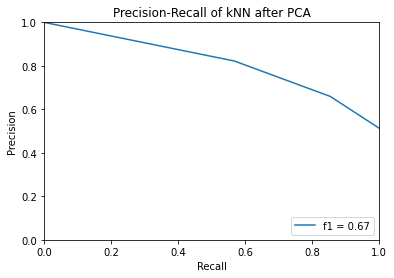

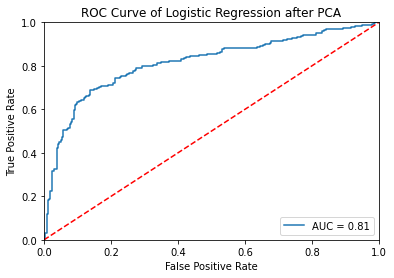

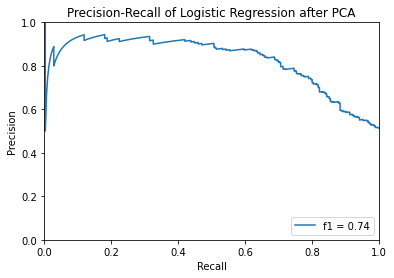

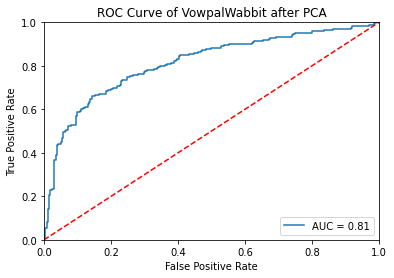

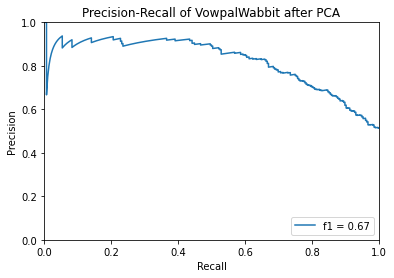

In [95]:
from sklearn.decomposition import PCA

X = final[["A", "T", "G", "C", "gc", "skew", "shannon", "melting_temp", "molecular_weight"] + all_kmers].transform(minmax_scale)
# Receptor 1, Ligand 0
Y = final["type"].transform(lambda x: 1 if x == "RECEPTOR" else 0)

pca = PCA(n_components=9 + 4)
pca.fit(X)
X_pca = pca.transform(X)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size = 0.35)


model = KNeighborsClassifier(2)
model.fit(X_train, Y_train)

predictions = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
precision, recall, threshold = precision_recall_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
f1 = f1_score(Y_test, predictions)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN after PCA')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of kNN after PCA')
plt.show()


# Logistic Reg
reg = LogisticRegression(max_iter=3000)
reg.fit(X_train, Y_train)

preds = reg.predict(X_test)
probs = reg.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)

precision, recall, threshold = precision_recall_curve(Y_test, probs)
f1 = f1_score(Y_test, preds)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression after PCA')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of Logistic Regression after PCA')
plt.show()


model = VWClassifier()
model.fit(X_train, Y_train)
    # predict model
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
precision, recall, threshold = precision_recall_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
f1 = f1_score(Y_test, predictions)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of VowpalWabbit after PCA')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of VowpalWabbit after PCA')
plt.show()

# KERAS

In [165]:
# Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

X = final[["A", "T", "G", "C", "gc", "skew", "shannon", "melting_temp", "molecular_weight"] + all_kmers].transform(minmax_scale)
# Receptor 1, Ligand 0
Y = final["type"].transform(lambda x: 1 if x == "RECEPTOR" else 0)

pca = PCA(n_components=9 + 4**2)
pca.fit(X)
X_pca = pca.transform(X)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size = 0.35)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
model = Sequential()
model.add(Dense(25, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=150, batch_size=X_train.shape[0])

original shape:    (1532, 1033)
transformed shape: (1532, 25)
Epoch 1/150
1/1 [==============================] - 1s 648ms/step - loss: 0.6863 - accuracy: 0.5347 - val_loss: 0.6869 - val_accuracy: 0.6313
Epoch 2/150
1/1 [==============================] - 0s 37ms/step - loss: 0.6850 - accuracy: 0.5920 - val_loss: 0.6859 - val_accuracy: 0.6443
Epoch 3/150
1/1 [==============================] - 0s 38ms/step - loss: 0.6836 - accuracy: 0.6191 - val_loss: 0.6850 - val_accuracy: 0.6611
Epoch 4/150
1/1 [==============================] - 0s 33ms/step - loss: 0.6823 - accuracy: 0.6281 - val_loss: 0.6840 - val_accuracy: 0.6536
Epoch 5/150
1/1 [==============================] - 0s 36ms/step - loss: 0.6809 - accuracy: 0.6382 - val_loss: 0.6830 - val_accuracy: 0.6574
Epoch 6/150
1/1 [==============================] - 0s 37ms/step - loss: 0.6795 - accuracy: 0.6382 - val_loss: 0.6819 - val_accuracy: 0.6518
Epoch 7/150
1/1 [==============================] - 0s 35ms/step - loss: 0.6781 - accuracy: 0.6412

Epoch 59/150
1/1 [==============================] - 0s 26ms/step - loss: 0.5816 - accuracy: 0.7467 - val_loss: 0.6106 - val_accuracy: 0.7095
Epoch 60/150
1/1 [==============================] - 0s 25ms/step - loss: 0.5796 - accuracy: 0.7467 - val_loss: 0.6092 - val_accuracy: 0.7076
Epoch 61/150
1/1 [==============================] - 0s 25ms/step - loss: 0.5776 - accuracy: 0.7467 - val_loss: 0.6079 - val_accuracy: 0.7076
Epoch 62/150
1/1 [==============================] - 0s 26ms/step - loss: 0.5756 - accuracy: 0.7477 - val_loss: 0.6066 - val_accuracy: 0.7095
Epoch 63/150
1/1 [==============================] - 0s 23ms/step - loss: 0.5736 - accuracy: 0.7497 - val_loss: 0.6053 - val_accuracy: 0.7076
Epoch 64/150
1/1 [==============================] - 0s 25ms/step - loss: 0.5716 - accuracy: 0.7497 - val_loss: 0.6040 - val_accuracy: 0.7076
Epoch 65/150
1/1 [==============================] - 0s 26ms/step - loss: 0.5697 - accuracy: 0.7497 - val_loss: 0.6027 - val_accuracy: 0.7076
Epoch 66/150


Epoch 117/150
1/1 [==============================] - 0s 26ms/step - loss: 0.4864 - accuracy: 0.7799 - val_loss: 0.5555 - val_accuracy: 0.7151
Epoch 118/150
1/1 [==============================] - 0s 26ms/step - loss: 0.4853 - accuracy: 0.7809 - val_loss: 0.5551 - val_accuracy: 0.7207
Epoch 119/150
1/1 [==============================] - 0s 25ms/step - loss: 0.4842 - accuracy: 0.7809 - val_loss: 0.5547 - val_accuracy: 0.7188
Epoch 120/150
1/1 [==============================] - 0s 25ms/step - loss: 0.4831 - accuracy: 0.7809 - val_loss: 0.5543 - val_accuracy: 0.7188
Epoch 121/150
1/1 [==============================] - 0s 26ms/step - loss: 0.4821 - accuracy: 0.7829 - val_loss: 0.5540 - val_accuracy: 0.7169
Epoch 122/150
1/1 [==============================] - 0s 28ms/step - loss: 0.4810 - accuracy: 0.7809 - val_loss: 0.5537 - val_accuracy: 0.7188
Epoch 123/150
1/1 [==============================] - 0s 26ms/step - loss: 0.4800 - accuracy: 0.7819 - val_loss: 0.5535 - val_accuracy: 0.7188
Epoch 

17/17 [==============================] - 0s 2ms/step
Accuracy := 71.88%


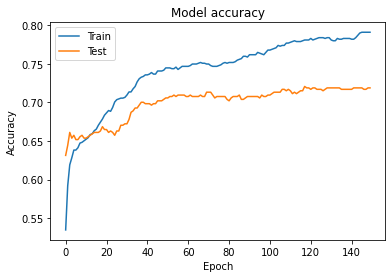

In [166]:
import numpy as np 
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
# Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
# Converting one hot encoded test label to label
test = list()
for i in range(len(Y_test)):
    test.append(np.argmax(Y_test[i]))
    
a = accuracy_score(pred, test)
print(f'Accuracy := {a * 100 :.2f}%')


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [167]:
from keras_visualizer import visualizer

visualizer(model, format='png', view=True)

Error: no "view" mailcap rules found for type "image/png"
